In [52]:
#import matplotlib
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import metpy.calc as mpc
import xarray as xr
import scipy.ndimage as ndimage
import pandas as pd
import datetime as dt
#from scam_func import *


In [140]:
''#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######
#scam_file_in = './FSCAM.T42_T42.SAS.001.cam.h0.2013-06-10-43200.nc'   # input template (default: 20min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.002.cam.h0.2013-06-10-43200.nc'   # input template (5min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.003.cam.h0.2013-06-10-43200.nc'   # input template (1min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.007.cam.h0.2013-06-10-43200.nc'   # input template, fixed q for SCAM (double,kg/kg), shflx/lhflx prescribed (default: 20min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.008.cam.h0.2013-06-10-43200.nc'   # as 007, but with omega,divT and divq set to zero.
#scam_file_in = './FSCAM.T42_T42.SAS.011b.cam.h0.2013-06-10-43200.nc'   # as 007, but with omega,divT and divq set to zero.

#xr.show_versions()
scam_file_num = '012a'  # For detailed single case analysis
#scam_file_nums = ['011a','011b','011c','011d']  # For comparisons
#scam_file_nums = ['012a','012b','012c','012d','012e','012f']  # For comparisons
#scam_file_nums = ['012a','012b','012f']
#scam_run_names = ['q_ft','0.5LS.T','no LS.Tq']

#scam_run_names = ['q_ft','0.5LS.T','0.5LS.q','0.5LS.Tq','0.25LS.Tq','no LS.Tq']

scam_file_nums = ['100a','100','100b','100c']
scam_run_names = ['L16','L32','L64','L128']

scam_file_pre = "FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-43200.nc"

zoffset = 6.


#### PLOTTING ####

pvars_ts1d = np.array(['TS','PBLH','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts2d = ['T','Q','RELHUM']
pvars_ts2d = ['T','Q','RELHUM','CLOUD','ZMDQ','ZMDT','STEND_CLUBB','RVMTEND_CLUBB'] # 2D profile timeseries plots
pvars_snap = ['T','Q','TH','THL']  # Snapshot plotting vars
pvars_anim = np.array(('T','RELHUM'))

tsnaps = np.array([6.,8.,10.,12.,14.,16])     # Time of snapshots (local time)


####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
%matplotlib inline


#### CONSTANTS #####

r_gas = 287.   # Specific gas constant for dry air
cp_air = 1004.6 # Specific heat for dry air
Lv = 2.501e6      # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = 9.81     # Gravity ave.
p0 = 100000. # pref 

###### DERIVED VARS #######
scam_files_in = [scam_file_pre+x+scam_file_suf for x in scam_file_nums]
print('++++ Runs ++++')
print('')
scam_file_in = scam_file_pre+scam_file_num+scam_file_suf 
scam_fig_stub='png/'+'_'.join(scam_file_nums)

rinfo = {}
rinfo['Run Name']  =  scam_run_names
rinfo['File Num']  =  scam_file_nums
rinfo['File Name'] =  scam_files_in

df_rinfo = pd.DataFrame(rinfo)
df_rinfo.style.set_properties(**{'background-color': 'black','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})
print(df_rinfo)
print('')

##### Point Files #######

scam_in = xr.open_mfdataset(scam_files_in,concat_dim='case',join='left',combine='nested')
#scam_in = xr.open_mfdataset(scam_files_in,concat_dim='case',combine='by_coords')
xr.set_options(keep_attrs=True)

## Dimensions ##

time = scam_in.time
hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset
vplevs = scam_in['lev'].transpose()
ntsnaps = tsnaps.size
ncases = len(scam_file_nums)

## Vertical range to plot

pptop = 200.
ipplevs = np.where(vplevs>=pptop) ; ip0 = np.min(ipplevs) ; ip1 = np.max(ipplevs)
vplevs_v = vplevs[ip0:ip1]

++++ Runs ++++

  Run Name File Num                                          File Name
0      L16     100a  FSCAM.T42_T42.SAS.100a.cam.h0.2013-06-10-43200.nc
1      L32      100   FSCAM.T42_T42.SAS.100.cam.h0.2013-06-10-43200.nc
2      L64     100b  FSCAM.T42_T42.SAS.100b.cam.h0.2013-06-10-43200.nc
3     L128     100c  FSCAM.T42_T42.SAS.100c.cam.h0.2013-06-10-43200.nc



          T RELHUM CLOUD     Q WPRTP_CLUBB WPTHLP_CLUBB WP3_CLUBB STEND_CLUBB  \
vscale    1      1   100  1000           1            1         1        86.4   
cmin    190     10     0     1           0            0        -1         -20   
cmax    330    120   100    20         200          200         1          20   
acmin   -20   -100   -80    -5         -50          -50      -0.5          -2   
acmax    20    100    80     5          50           50       0.5           2   
units     K      %     %  g/kg        W/m2         W/m2     m3/s3       K/day   

       RVMTEND_CLUBB       DCQ  THL   ZMDT      ZMDQ  
vscale      8.64e+07      1000    1  86400  8.64e+07  
cmin             -50        -5  210    -10        -2  
cmax              50         5  310     10         2  
acmin            -20        -5  -20    -10        -8  
acmax             20         5   20     10         8  
units       g/kg/day  g/kg/day    K  K/day  g/kg/day  
---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   

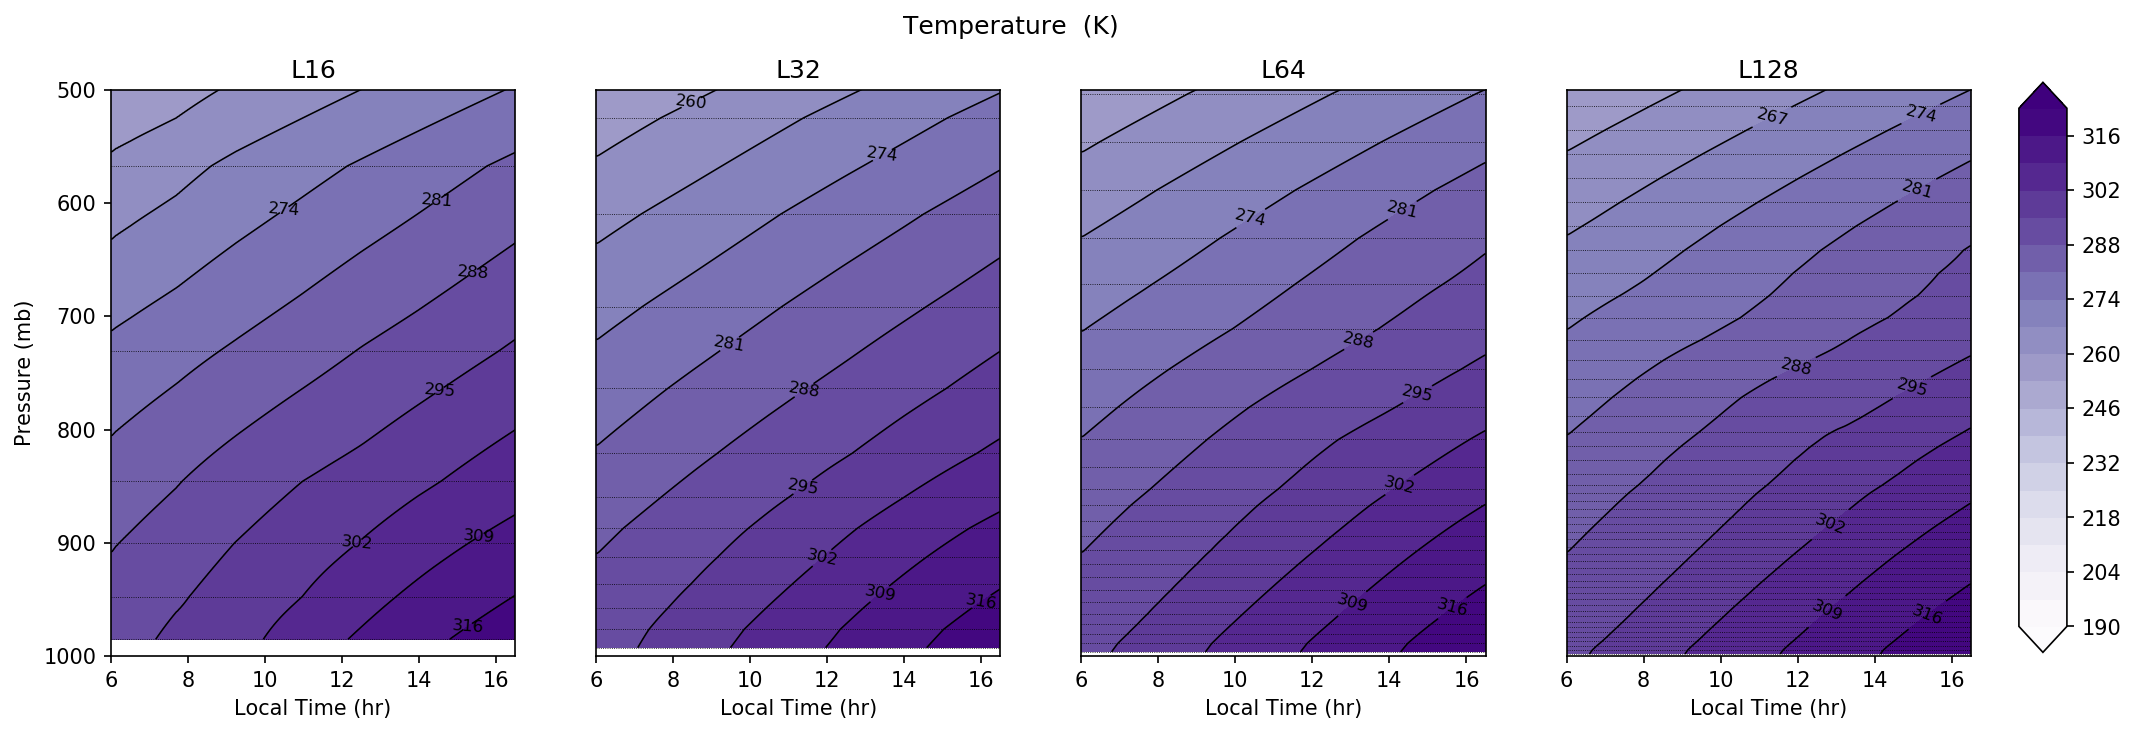

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Specific humidity  -- cmin/cmax -->  1.0 20.0
Case =  100a Range= 1e-12 0.013720664
Case =  100 Range= 1e-09 16.305647
Case =  100b Range= 1e-09 17.425999
Case =  100c Range= 1e-09 17.940361


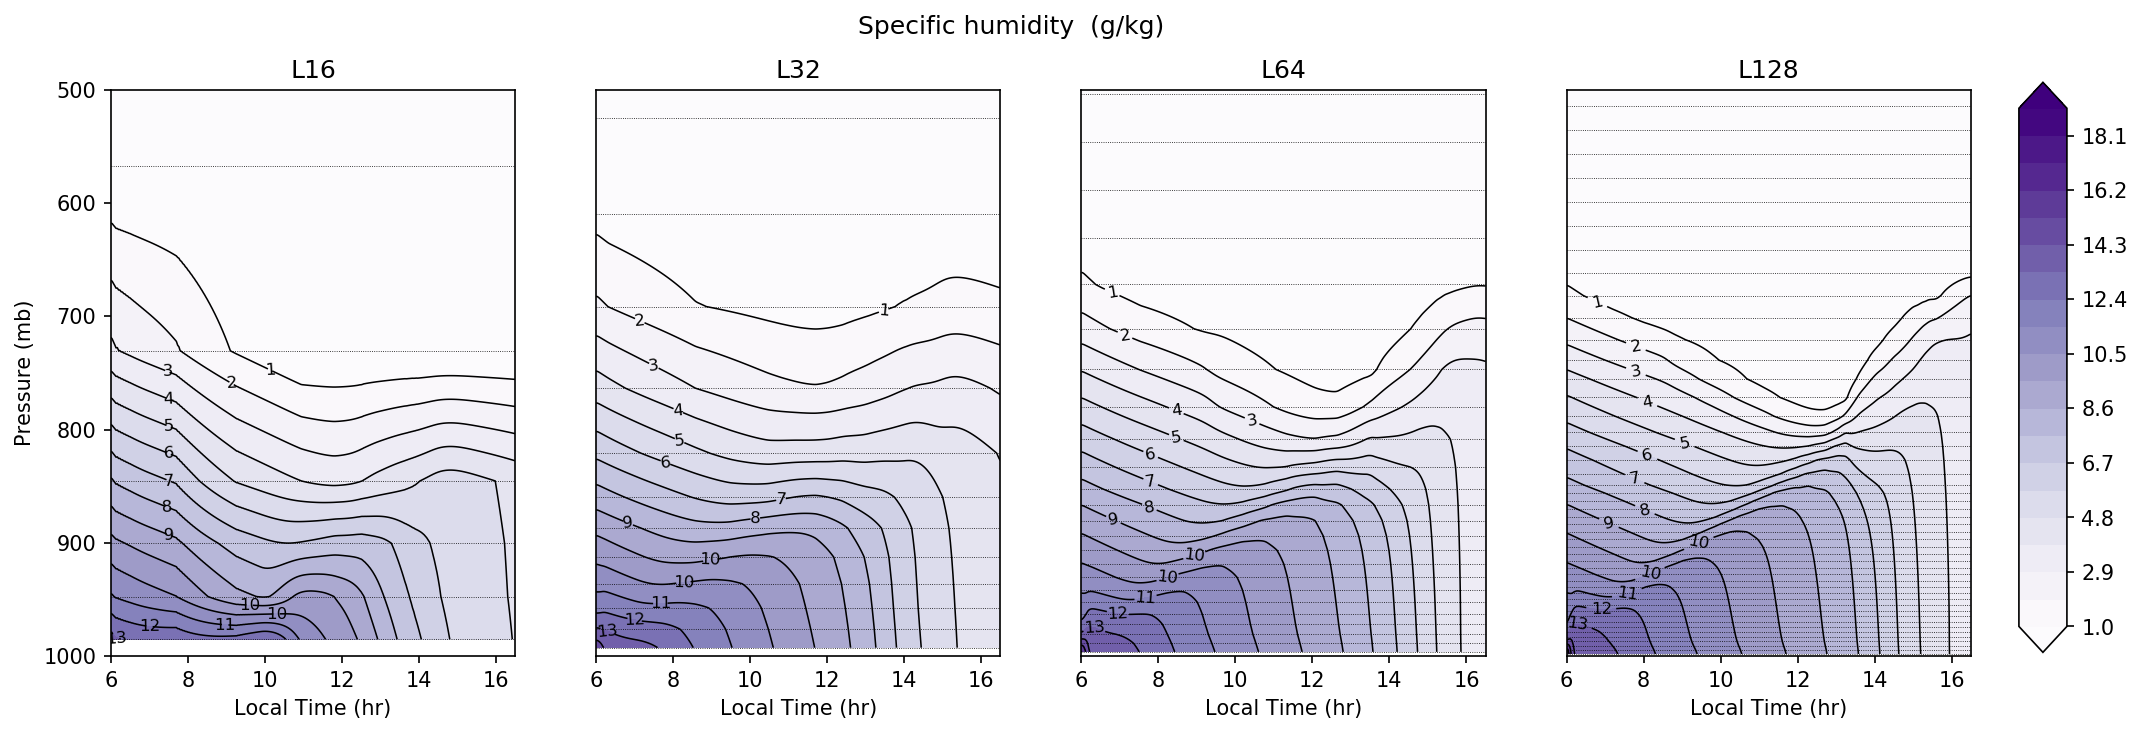

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Relative humidity  -- cmin/cmax -->  10.0 120.0
Case =  100a Range= 4.0730797e-09 91.98174
Case =  100 Range= 4.991402e-09 101.781136
Case =  100b Range= 5.5681046e-09 103.11975
Case =  100c Range= 5.5287286e-09 102.06945


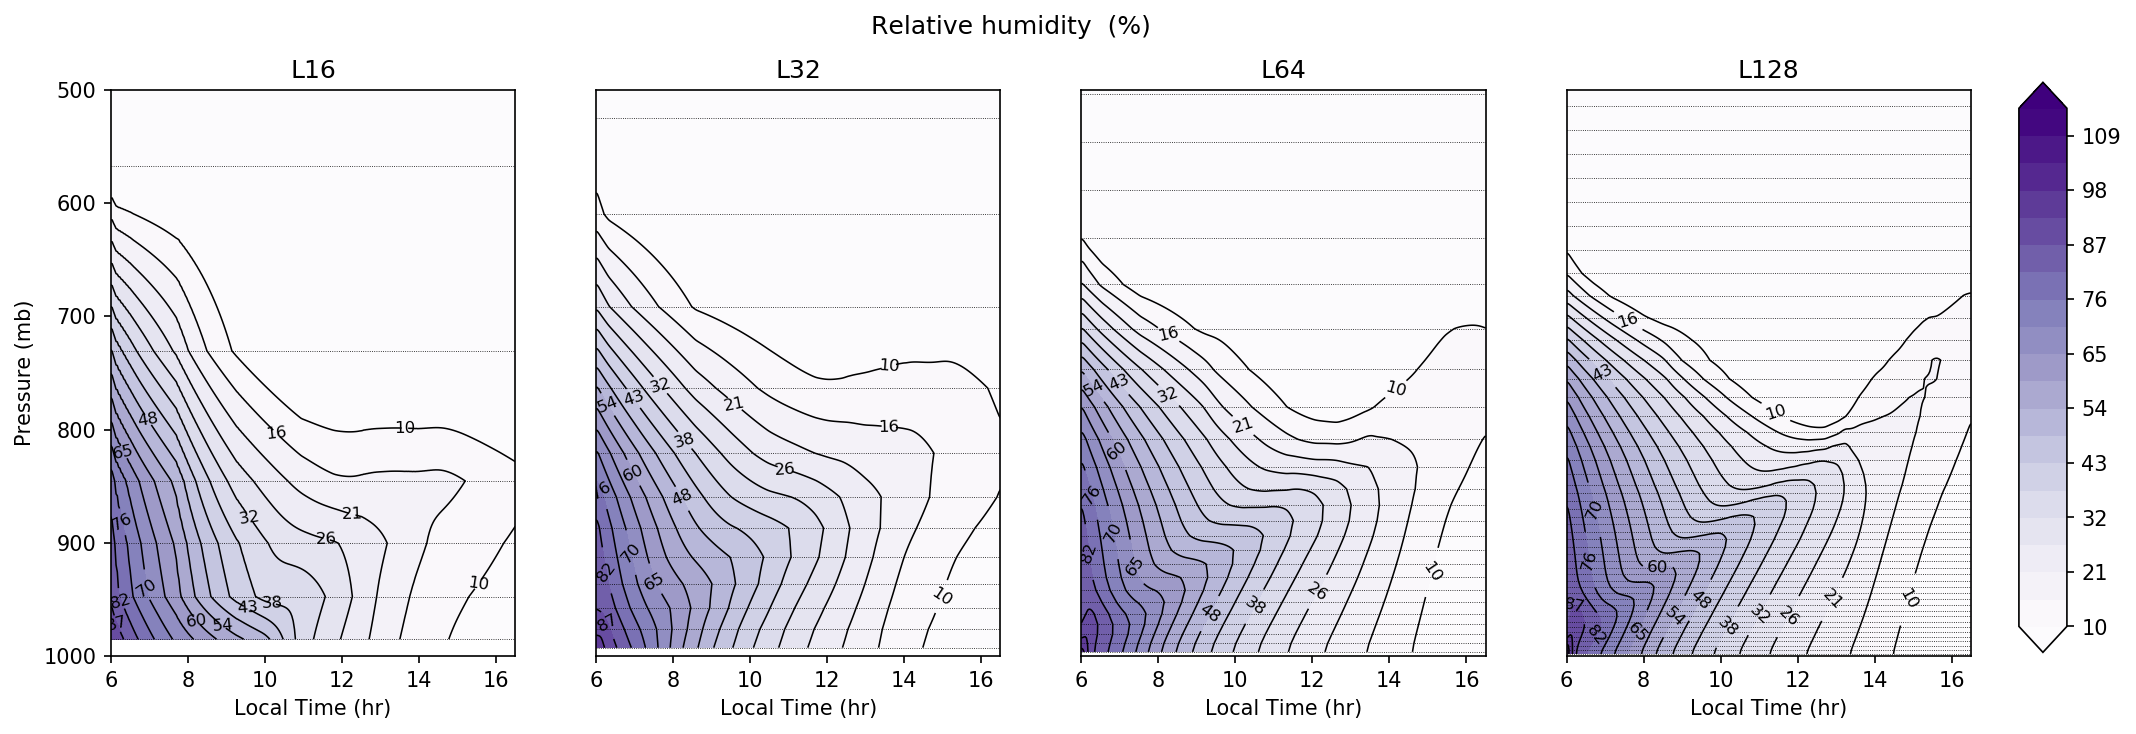

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Cloud fraction  -- cmin/cmax -->  0.0 100.0
Case =  100a Range= 0.0 0.44041395
Case =  100 Range= 0.0 95.55363
Case =  100b Range= 0.0 100.0
Case =  100c Range= 0.0 100.0


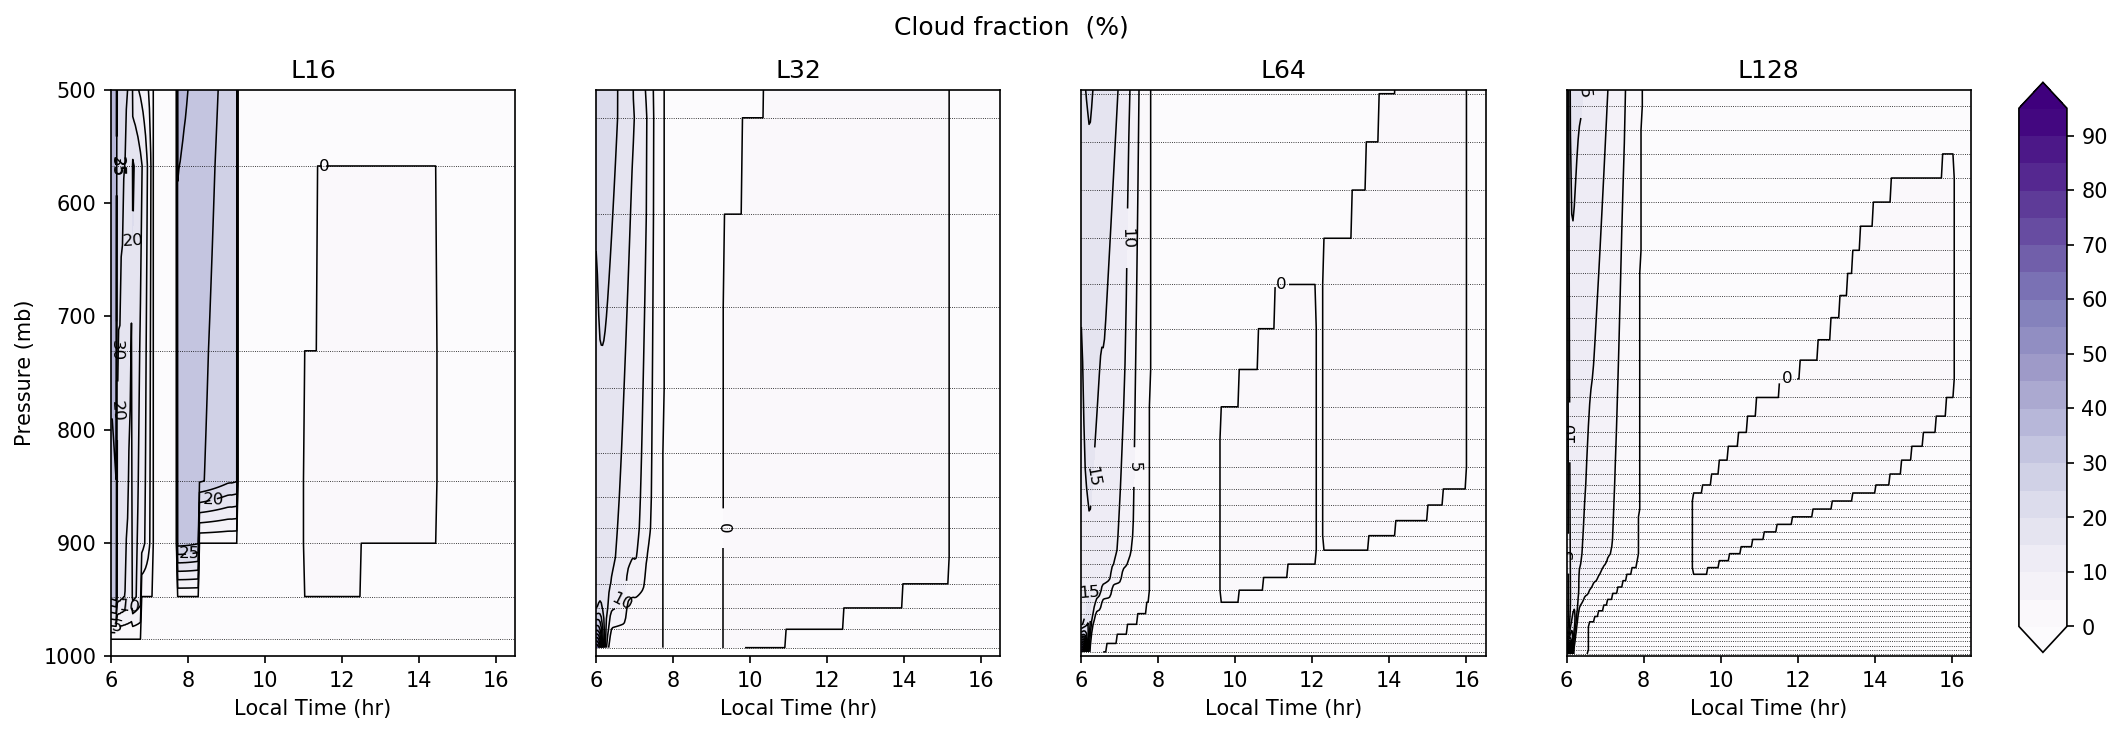

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Q tendency - Zhang-McFarlane moist convection  -- cmin/cmax -->  -2 2.0
Case =  100a Range= -6.0446763e-07 3.343498e-08
Case =  100 Range= -25.059404 2.9071546
Case =  100b Range= -30.346594 2.7076652
Case =  100c Range= -34.075577 2.8866823


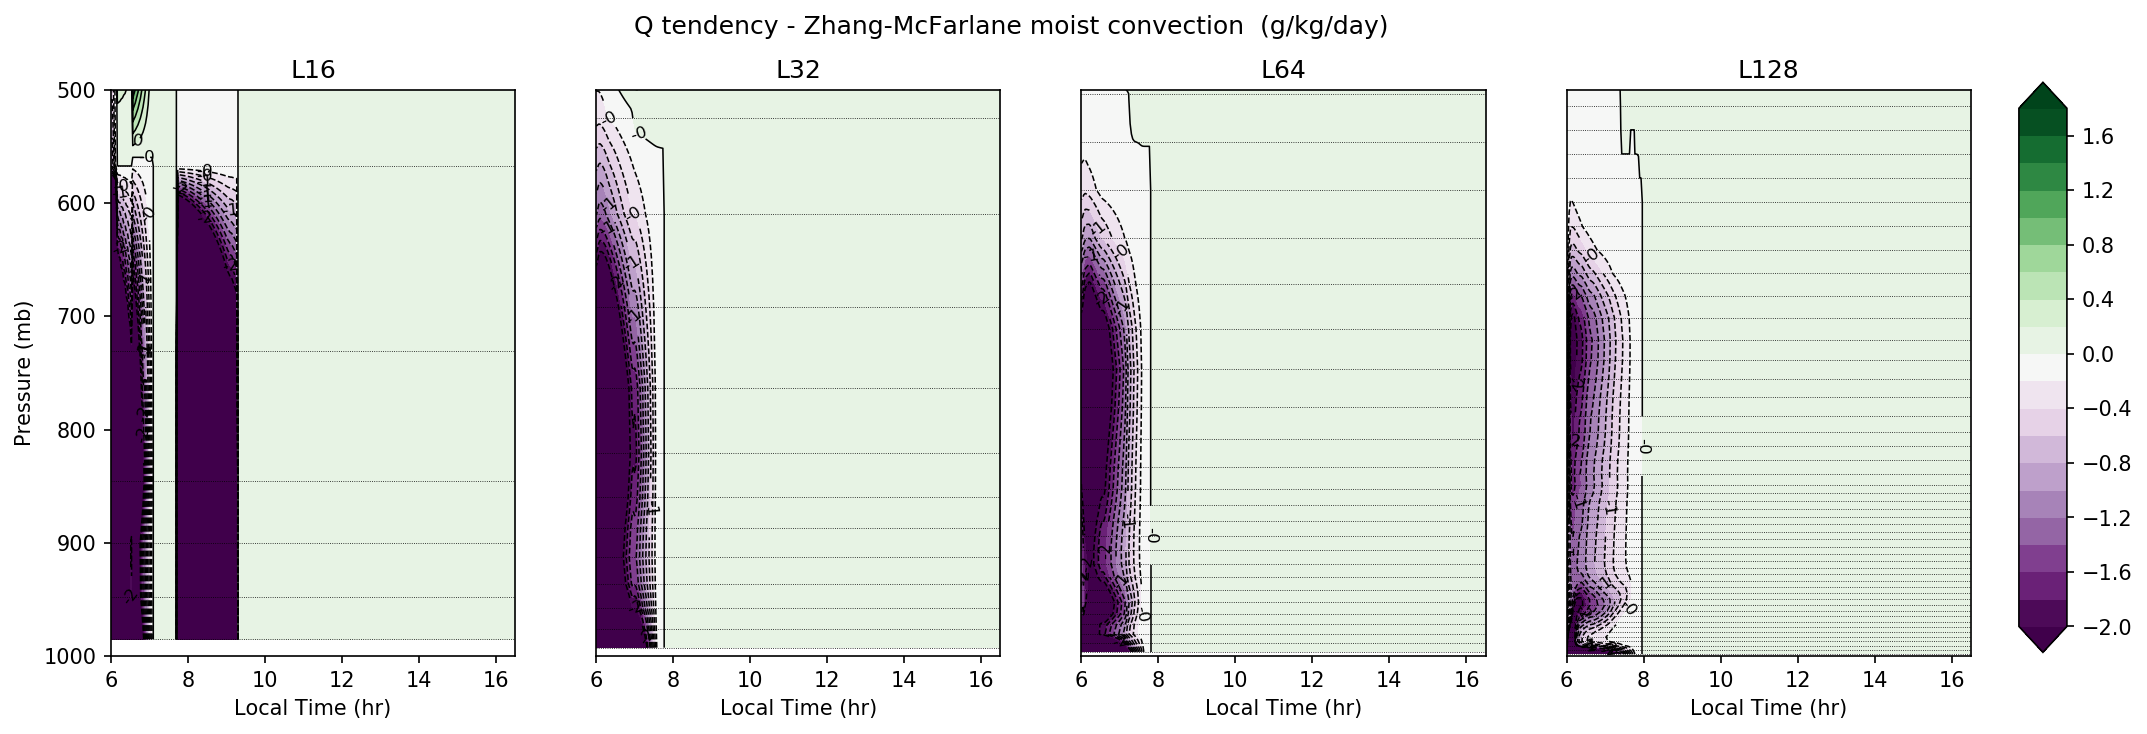

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   T tendency - Zhang-McFarlane moist convection  -- cmin/cmax -->  -10.0 10.0
Case =  100a Range= -0.0005130756 0.000598678
Case =  100 Range= -17.923855 27.157372
Case =  100b Range= -26.727283 38.122932
Case =  100c Range= -32.848373 57.901466


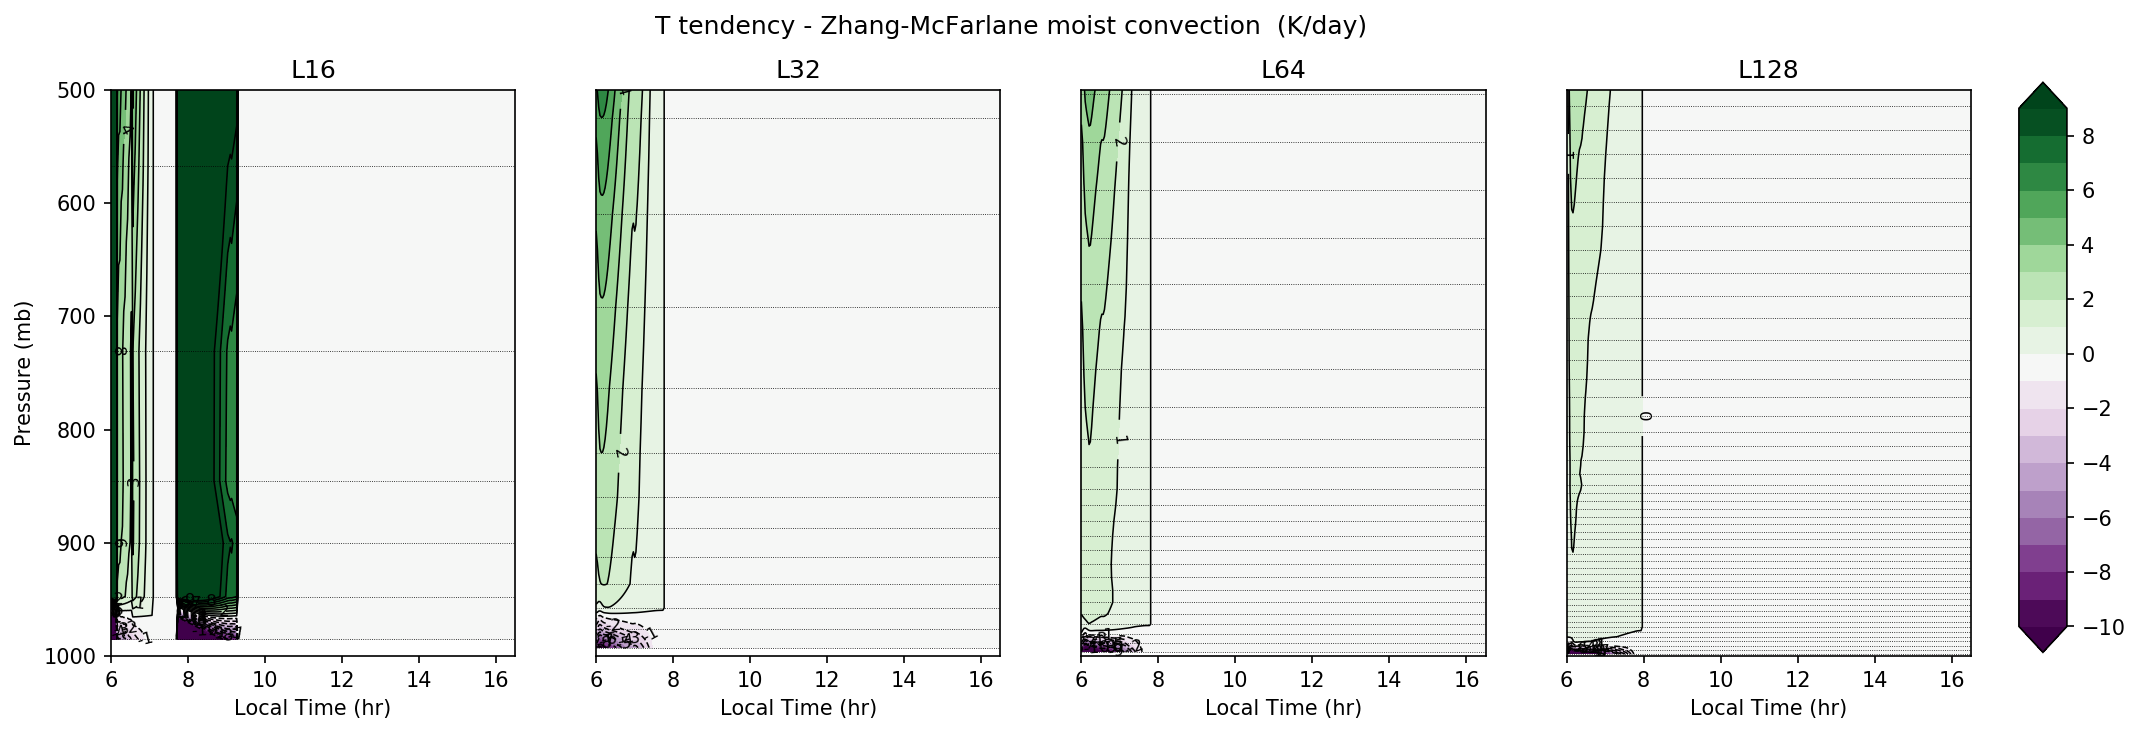

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Static energy tendency  -- cmin/cmax -->  -20 20
Case =  100a Range= -0.057674214 0.33612353
Case =  100 Range= -91.87295 564.7671
Case =  100b Range= -199.82547 1076.0756
Case =  100c Range= -324.98666 1463.8977


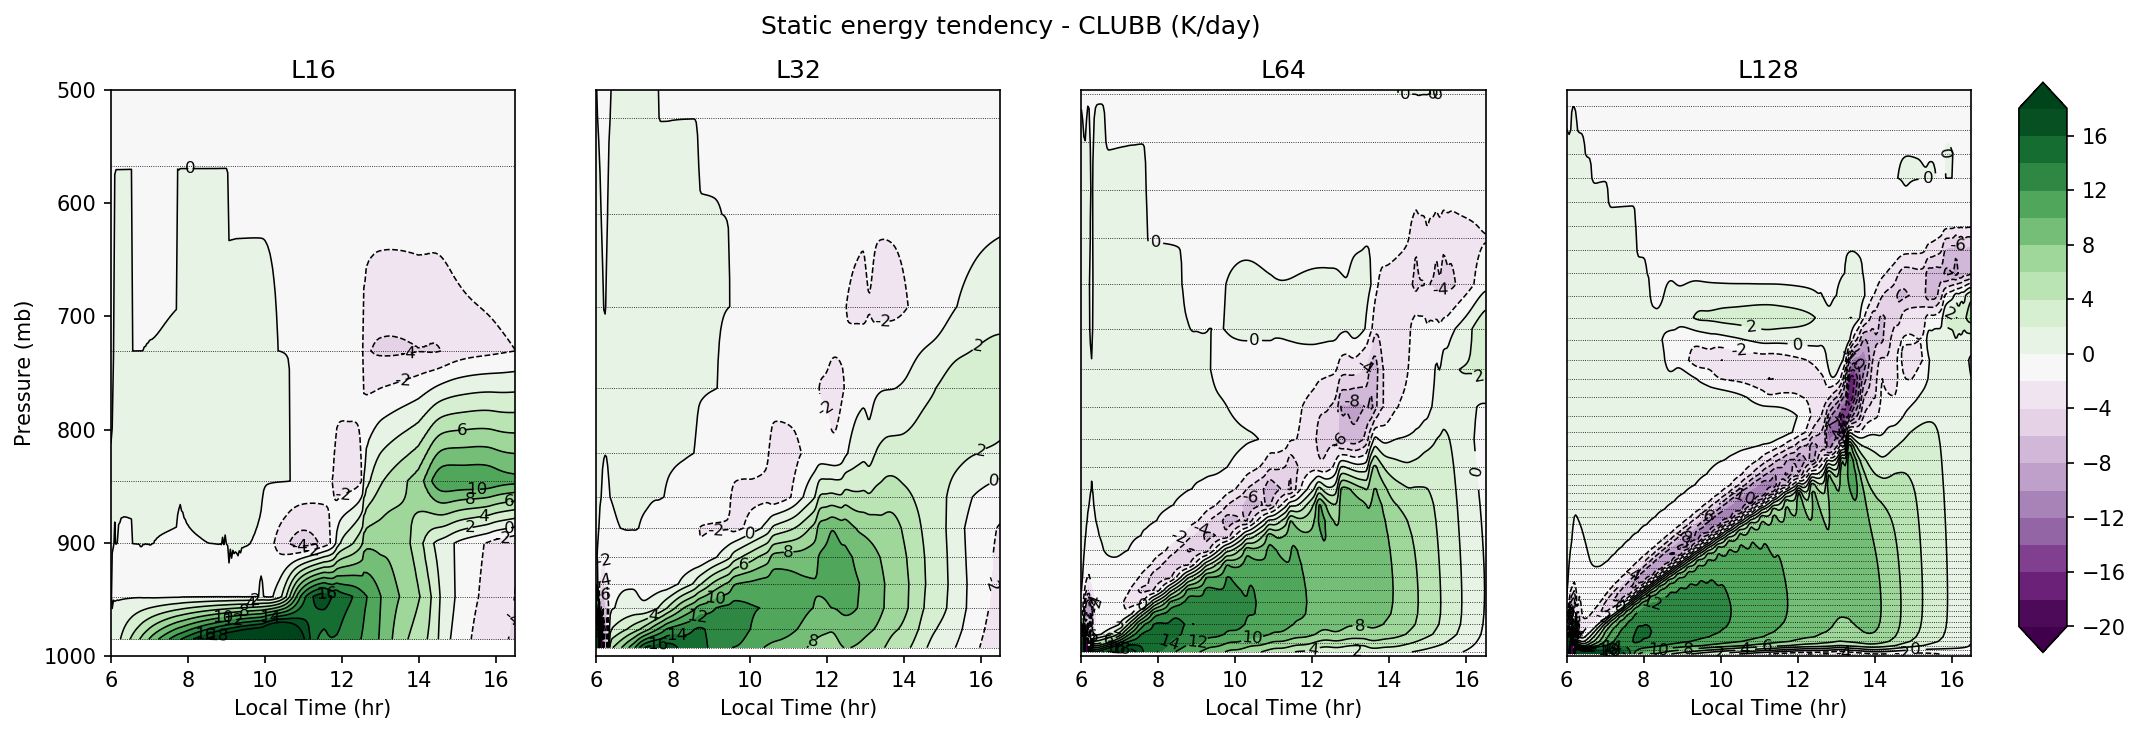

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Water vapor tendency  -- cmin/cmax -->  -50.0 50.0
Case =  100a Range= -6.567637e-07 6.649896e-07
Case =  100 Range= -240.0445 114.946205
Case =  100b Range= -465.5443 213.99048
Case =  100c Range= -720.7554 333.12067


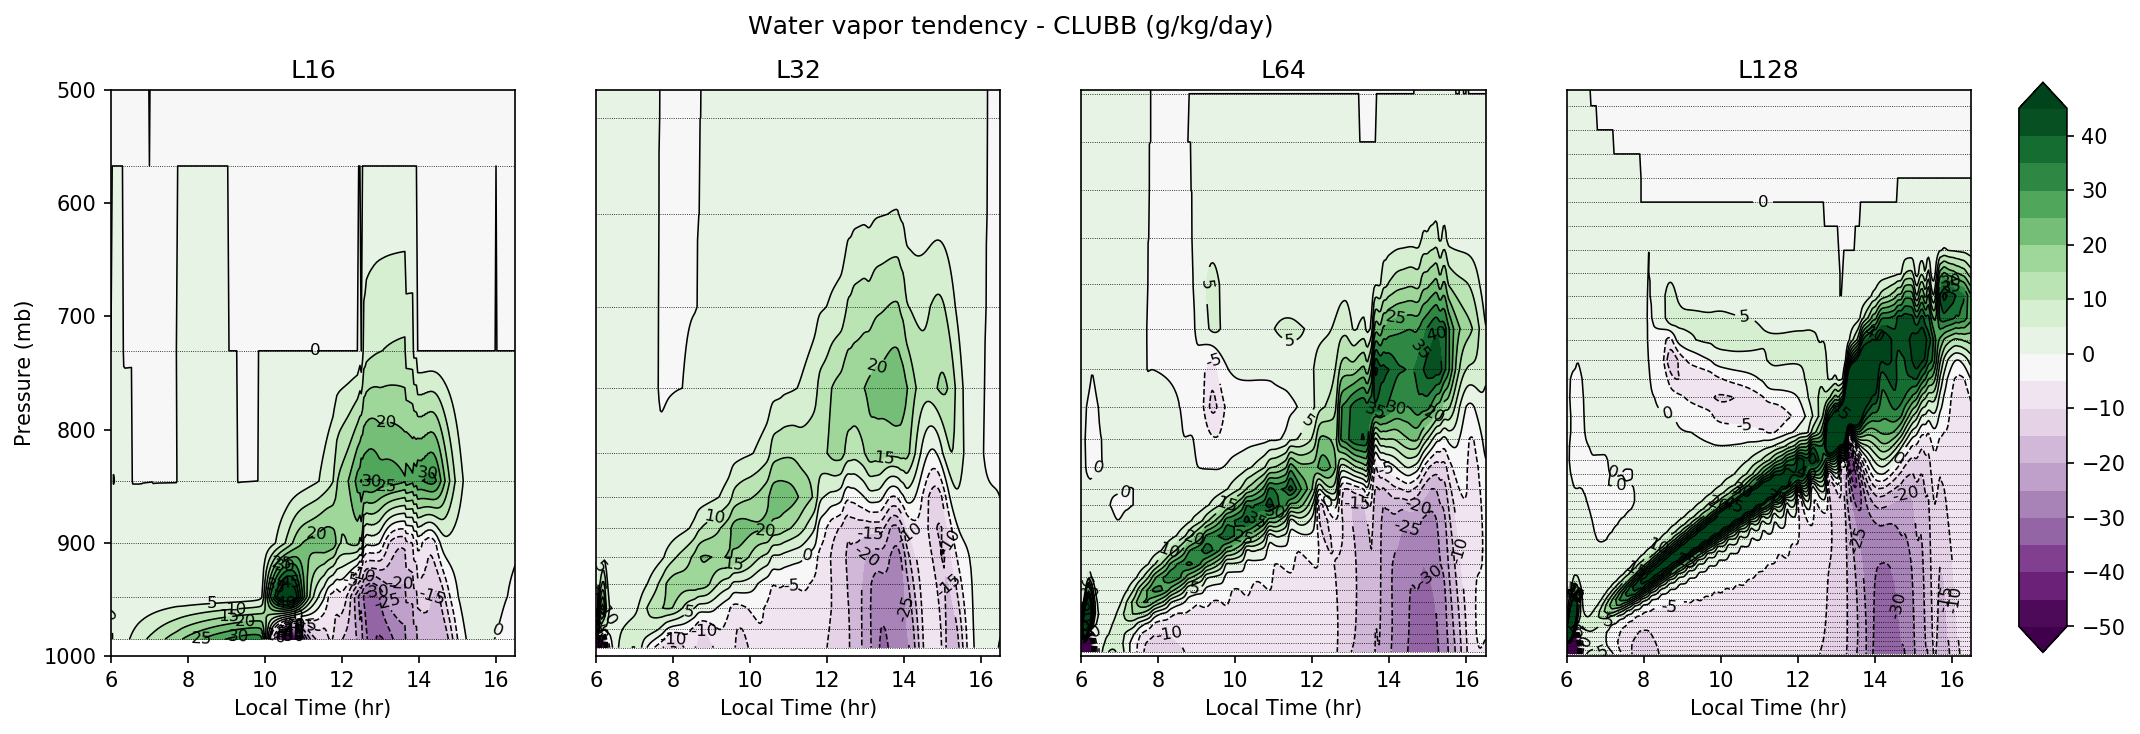

In [143]:
###### Plotting ##########

#plot1d_ts_scam()   # 1D time series plots
plot2d_ts_scam()   # 2D time series plots
#plot1d_snap_scam()   # 1D snapshot plots
#plot1d_anim_scam() # 2D animation  plots


In [106]:
#fig = mp.figure()
#ax = mp.axes(xlim=(0, 4), ylim=(-2, 2))
#line, = ax.plot([], [], lw=3)

#def init():
#    line.set_data([], [])
#    return line,
#def animate(i):
#    x = np.linspace(0, 4, 1000)
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
#    line.set_data(x, y)
#    return line,

#anim = FuncAnimation(fig, animate, init_func=init,
##                               frames=100, interval=40, blit=True)
#HTML(anim.to_html5_video())


#mp.show()

#fig.show()
#anim.save('sine_wave.gif', writer='imagemagick')


In [74]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "none"

In [75]:

################################
#   1D Timeseries plotting     #
################################


def plot1d_ts_scam():
    
    plot1d_dic = {}

    plot1d_dic['LHFLX']  = [1.,0.,300]
    plot1d_dic['SHFLX']  = [1.,0., 300]
    plot1d_dic['TS']     = [1., 290., 300.]
    plot1d_dic['PBLH']   = [1., 0., 1000.]
    plot1d_dic['PRECL']  = [86400.*1000., 0., 10.]
    plot1d_dic['PRECC']  = [86400.*1000., 0., 10.]
    plot1d_dic['FLNS']   = [1., 200., 800.]
    plot1d_dic['CAPE']   = [1., 0., 800.]

    plot1d_df = pd.DataFrame(plot1d_dic,index=['vscale','cmin','cmax'])
    print(plot1d_df)
    
    vleg_left = ['PBLH']
    

## 1D PLOTS ##
#mp.rcParams['figure.dpi'] = 50

    for var in pvars_ts1d:
 
        vscale = plot1d_dic[var][0] ; cmin = plot1d_dic[var][1] ; cmax = plot1d_dic[var][2]
       
        vleg_x=0.085 if var in vleg_left else 0.97
            
        with xr.set_options(keep_attrs=True): 
            pvar = vscale*scam_in[var].isel(lat=0,lon=0)

#        pvarp = pvar[0,:]
#        # Fig. setup
        print('---- PLOTTING 1D TIME PLOTS ------>>>  ',pvar.attrs['long_name'])
#        print(scam_file_nums[0], ' --cmin/cmax --> ',  np.min(pvarp.values),np.max(pvarp.values))
        
        # Loop cases and plot
        for icase in range(0,ncases):
            pvarp = pvar[icase,:] 
            print(scam_file_nums[icase], ' --cmin/cmax --> ',  np.min(pvarp.values),np.max(pvarp.values))
            mp.plot(hour_frac,pvarp)

    
    # Axes stuff
        mp.xlabel("Local Time (hr)")
        mp.ylabel(pvar.attrs['units'])
        mp.title(pvar.attrs['long_name'])
        
#        mp.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        mp.legend(labels=scam_run_names, ncol=1, fontsize="medium",
                columnspacing=1.0, labelspacing=0.8, bbox_to_anchor= (vleg_x, 0.83),
                handletextpad=0.5, handlelength=1.5, borderaxespad=-5,
                framealpha=1.0,frameon=True)
#        mp.show()
        mp.savefig(scam_fig_stub+'_plot1d_ts_scam_'+var+'.png')     
        mp.close()
        
        
        
        
   

In [142]:
############################################
#  2D Time/Height Timeseries Plotting info. #
############################################ 


def plot2d_ts_scam():

    plot2d_dic = {}

    plot2d_dic['T']      = [1.,190.,330.,-20.,20.,scam_in['T'].attrs['units']]
    plot2d_dic['RELHUM'] = [1.,10., 120.,-100.,100.,'%']
    plot2d_dic['CLOUD']  = [100., 0., 100.,-80.,80.,'%']
    plot2d_dic['Q']      = [1000., 1., 20.,-5,5.,'g/kg']
    plot2d_dic['WPRTP_CLUBB'] = [1., 0., 200.,-50.,50.,scam_in['WPRTP_CLUBB'].attrs['units']]
    plot2d_dic['WPTHLP_CLUBB'] = [1., 0., 200.,-50.,50.,scam_in['WPTHLP_CLUBB'].attrs['units']]
    plot2d_dic['WP3_CLUBB']      = [1., -1., 1.,-0.5,0.5,scam_in['WP3_CLUBB'].attrs['units']]
    plot2d_dic['STEND_CLUBB']    = [86400./1000., -20, 20,-2.,2.,'K/day'] #J/kg.s -> K/day
    plot2d_dic['RVMTEND_CLUBB']  = [1000.*86400, -50., 50.,-20.,20.,'g/kg/day']
    plot2d_dic['DCQ']  = [1000., -5., 5.,-5.,5.,'g/kg/day']
    plot2d_dic['THL']  = [1., 210, 310.,-20.,20.,scam_in['T'].attrs['units']]
    plot2d_dic['ZMDT']  = [86400., -10., 10.,-10.,10.,'K/day']
    plot2d_dic['ZMDQ']  = [86400.*1000., -2, 2.,-8.,8.,'g/kg/day']

    var_cmap0 = ['T','RELHUM','Q','CLOUD','THL']
    
    plot2d_df = pd.DataFrame(plot2d_dic,index=['vscale','cmin','cmax','acmin','acmax','units'])
    print(plot2d_df)

    nclevs = 20 # Number of contour levels
    ppmin = 500. ; ppmax = 1000. # Pressure (mb) plot range
    ptype = 'full' # Full/anom/diff 
    cmap_full = 'Purples'
    cmap_anom = 'PRGn'
    
    
   
    
## TIME/HEIGHT PLOTTING ##
    mp.rcParams['figure.dpi'] = 150

    
    ## VARIABLE LOOP ##
    for var in pvars_ts2d:

        # Scaling and contour intervals
        vscale = plot2d_dic[var][0] ; cmin = plot2d_dic[var][1] ; cmax = plot2d_dic[var][2]
        plevels = np.arange(cmin,cmax,(cmax-cmin)/nclevs)        
            
        acmin = plot2d_dic[var][3] ; acmax = plot2d_dic[var][4]
        aplevels = np.arange(acmin,acmax,(acmax-acmin)/nclevs)
        
        if ptype =='full': aplevels=plevels # Set to plevels if all full fields
    
        # Color maps for negative valued filled.
        pcmap=cmap_full if var in var_cmap0 else cmap_anom
           
        # First case plot (could be only plot)
        scam_icase = xr.open_dataset(scam_files_in[0],engine='netcdf4') 
        pvar = scam_icase[var].isel(lat=0,lon=0).transpose()
        plev = scam_icase['lev']
        
        print('---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  ',pvar.attrs['long_name'],' -- cmin/cmax --> ',cmin,cmax)               
        print('Case = ',scam_file_nums[0],'Range=',np.min(pvar.values),np.max(pvar.values))
        
##############             
# First plot #
##############
        fig1 = mp.figure(figsize=(16, 5))
        ax1 = fig1.add_subplot(111)
        pvar0 = vscale*pvar
       
       
#        pvarp = pvarp-pvarp[:,0] # Remove initial column values

        plt0 = ax1.contourf(hour_frac,plev,pvar0,levels=plevels,cmap=pcmap,extend='both')   
        if ptype !='full': mp.colorbar(plt0, extend='both')
        plt0 = ax1.contour(hour_frac,plev,pvar0,levels=plevels,colors='black',linewidths=0.75)       
        
        ax1.clabel(plt0, fontsize=8, colors='black', fmt='%1.0f')

        mp.hlines(plev, min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.4)
        mp.suptitle(pvar.attrs['long_name']+(' - CLUBB' if 'CLUBB' in var else ' ')+' ('+plot2d_dic[var][5]+')')
        
        ax1.set_title(scam_run_names[0])
        ax1.set_ylabel('Pressure (mb)') 
        ax1.set_xlabel("Local Time (hr)")  
        ax1.set_ylim(ppmin, ppmax)
        ax1.invert_yaxis()  
        
                
#################################
# Loop for subsequent sub-plots #
#################################
        nn = len(fig1.axes)
    
        for icase in range(1,ncases):
           
            scam_icase = xr.open_dataset(scam_files_in[icase],engine='netcdf4') 
            pvarp = vscale*scam_icase[var].isel(lat=0,lon=0).transpose()
            plev = scam_icase['lev']
            print('Case = ',scam_file_nums[icase],'Range=',np.min(pvarp.values),np.max(pvarp.values))
            
            # Remove initial column values (anom) or case0 (diff)
            if ptype == 'anom' : pvarp = pvarp-pvar0 ; pcmap = cmap_anom
            if ptype == 'diff' : pvarp = pvarp-pvarp[:,0] ; pcmap = cmap_anom

            
            nn = len(fig1.axes)
           
            for i in range(nn):
                fig1.axes[i].change_geometry(1, nn+1, i+1)
            ax1 = fig1.add_subplot(1, nn+1, nn+1)
  
              
            pvarp_sm = ndimage.gaussian_filter(pvarp, sigma=1, order=0)
 
           
            plt0 = ax1.contourf(hour_frac,plev,pvarp_sm,levels=aplevels,cmap=pcmap,extend='both')

            # Squeeze in colorbar here so it doesn't get messed up by line contours
            mp.hlines(plev, min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.4)

            if icase==ncases-1: 
                mp.subplots_adjust(right=0.9)  
                mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))
            plt0 = ax1.contour(hour_frac,plev,pvarp_sm,levels=aplevels, colors='black',linewidths=0.75)
            
                
            ax1.clabel(plt0, fontsize=8, colors='black', fmt='%1.0f')
            
            
            
            ax1.set_title(scam_run_names[icase])
            ax1.set_xlabel("Local Time (hr)")
            ax1.set_ylim(ppmin, ppmax)
           
            ax1.yaxis.set_visible(False) # Remove y labels
            ax1.invert_yaxis()

       
            
## Plot ##
            
        # Scooch up plots to make room for a colorbar on the RHS   
#        mp.subplots_adjust(right=0.9)  
#        mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))
        
        mp.show()
        del pvar       
        
        
        
     

In [130]:
   
        
        
        
##########################################
# 2D Snapshot/Height Timeseries Plotting info.
##########################################


def plot1d_snap_scam():
              
    for var in pvars_snap:

        pvar = None

        if var =='TH' : pvar = scam_in['T'].isel(lat=0,lon=0)*(0.01*p0/vplevs)**r_cp ; pvar.attrs['long_name'] = "Potential Temperature" ; pvar.attrs['units'] = "K" ; theta = pvar
        if var =='THL': pvar = theta-(theta/scam_in['T'].isel(lat=0,lon=0))*(Lv/cp_air)*scam_in['Q'].isel(lat=0,lon=0) ; pvar.attrs['long_name'] = "Liq. Water Potential Temperature"

        if pvar is None :  # Set pvar if not already.
            pvar = scam_in[var].isel(lat=0,lon=0)

        print('------ SNAPSHOTS ------>>>  ',var,' --- ',pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

        # Plot several different functions...

        labelspacing = []
        labels = []

        ## Loop Snapshot Times ##

        for ii in range(0, ntsnaps): 
            itt = np.min(np.where(hour_frac==tsnaps[ii]))
            pvar_v = pvar[itt,ip0:ip1]
            mp.plot(pvar_v,vplevs_v)

    #        if var not in ['T','TH','THL']: mp.vlines(0, 0, scam_in[pvar.dims[1]].max(), linestyle="dashed",lw=1)
            mp.hlines(vplevs_v, min(pvar_v), max(pvar_v), linestyle="dotted",lw=0.04)

######### END of snapshot loop #########

    # Legend
        mp.title(pvar.attrs['long_name']+' ('+pvar.attrs['units']+')')
        mp.legend(labels=tsnaps, ncol=2, loc="center right", 
                columnspacing=1.0, labelspacing=1, 
                handletextpad=0.5, handlelength=0.5, frameon=False)
        print(pvar.attrs['units'])
        mp.gca().invert_yaxis()
        mp.show()
        del pvar       

        
        
        
        
        
        
        

In [7]:

#########################################
# 1D/TIME ANIMATIONS
#########################################

        
        
        
        
def plot1d_anim_scam():
    
    nanim_vars = pvars_anim.size
    
#    fig, ax = mp.subplots(nrows=1, ncols=nanim_vars,figsize=(15, 5)))
   
    
# 
#    def init():
#        line.set_data([], [])
#        return line,
#    def animate(i):
#        x = np.linspace(0, 4, 1000)
#        y = np.sin(2 * np.pi * (x - 0.01 * i))
#        line.set_data(x, y)
#        return line,

#    line, = ax.plot(x, np.sin(x))
          
    for var in pvars_anim:

        pvar = None

        if var =='TH': pvar = scam_in['T'].isel(lat=0,lon=0)*(0.01*p0/vplevs)**r_cp ; pvar.attrs['long_name'] = "Potential Temperature" ; pvar.attrs['units'] = "K" ; theta = pvar
        if var =='THL': pvar = theta-(theta/scam_in['T'].isel(lat=0,lon=0))*(Lv/cp_air)*scam_in['Q'].isel(lat=0,lon=0) ; pvar.attrs['long_name'] = "Liq. Water Potential Temperature"

        if pvar is None :  # Set pvar if not already.
            pvar = scam_in[var].isel(lat=0,lon=0)

        print('------ Animations ------>>>  ',var,' --- ',pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

    # Dynamically allocate subplots and animate Animate

#    ax.plot(pvar[0,:],vplevs) ;  ax.invert_yaxis()
    
  
    fig = mp.figure()
    
    
# Plotting frame.    
    ax = fig.add_subplot(111)
    ax.set_ylabel('mb') 
    for ip in range(1,5):
        n = len(fig.axes)
        print(n)
        for i in range(n):
            fig.axes[i].change_geometry(1, n+1, i+1)
        ax = fig.add_subplot(1, n+1, n+1)   
        
    def animate(ii):
        print(n)
        for i in range(n):
            ax[n].plot[i](pvar[ii,:],vplevs) 
    
#        del fig.axes
#        mp.show()
#        return ax
        
        
#    def animate(ii):
#        print(len(fig.axes))
#        ax = fig.add_subplot(111)
#        
#        ax.set_ylabel('mb') 
#        ax.plot(pvar[ii,:],vplevs) ;  ax.invert_yaxis()
#        for ip in range(1,2):
#            n = len(fig.axes)
#            print("hi2",n)
#            for i in range(n):
#                fig.axes[i].change_geometry(1, n+1, i+1)
#            ax = fig.add_subplot(1, n+1, n+1)
#            ax.plot(pvar[ii,:],vplevs) ;  ax.invert_yaxis()
#        del fig.axes
#        mp.show()
#        return ax
    print(fig.axes)
    animate(0)
    mp.show()
    
#    print(fig)
#    animate(1)
#    print(fig)
#    animate(200)
        
#
#       def init():
#        line.set_data([], [])
#        return line,     
    
#       def animate(i):
#        x = np.linspace(0, 4, 1000)
#        y = np.sin(2 * np.pi * (x - 0.01 * i))
#        line.set_data(x, y)
#        return line, 
#        for ip in range(pvars_anim.size-1):
#            n = len(fig.axes)
#            for i in range(n):
#                fig.axes[i].change_geometry(1, n+1, i+1)
#            ax = fig.add_subplot(1, n+1, n+1)
#            ax.plot(pvar[0,:],vplevs) ;  ax.invert_yaxis()
        
        
    anim = FuncAnimation(fig, animate, frames=np.arange(1,10))
#    print(anim)
    #    mp.show()
    mp.show()
    HTML(anim.to_html5_video())

    del pvar
    
   